In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/language-detection/Language Detection.csv


In [2]:
!pip install torchinfo tqdm

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import time
from collections import Counter
import re # For text cleaning
from tqdm.notebook import tqdm
import platform
import psutil
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
cpu_info = platform.processor()
ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)
try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"
print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

# Seed Value for reproducibility
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False # Set to True for slightly faster training if not concerned about exact reproducibility

# Device Variable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB
Using device: cuda


In [5]:
# Adjust this path based on where you add the dataset on Kaggle
data_path = "/kaggle/input/language-detection/Language Detection.csv"
df = pd.read_csv(data_path)

print("Original DataFrame head:")
print(df.head())
print("\nOriginal DataFrame info:")
df.info()
print("\nLanguage distribution:")
print(df['Language'].value_counts())

Original DataFrame head:
                                                Text Language
0   Nature, in the broadest sense, is the natural...  English
1  "Nature" can refer to the phenomena of the phy...  English
2  The study of nature is a large, if not the onl...  English
3  Although humans are part of nature, human acti...  English
4  [1] The word nature is borrowed from the Old F...  English

Original DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      10337 non-null  object
 1   Language  10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB

Language distribution:
Language
English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil         

In [6]:
# Clean text: remove special characters, convert to lowercase
def clean_text(text):
    text = text.lower()
    # Keep only lowercase letters and spaces. Remove numbers and punctuation.
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['Text'] = df['Text'].apply(clean_text)

# Create vocabulary (character-level for language detection is often effective)
# Add a special token for padding and unknown characters
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

all_characters = Counter()
for text in df['Text']:
    all_characters.update(list(text))

# Create char-to-idx and idx-to-char mappings
# Start with special tokens, then sorted unique characters
vocab_chars = [PAD_TOKEN, UNK_TOKEN] + sorted([char for char, count in all_characters.items() if char not in [PAD_TOKEN, UNK_TOKEN]])
char_to_idx = {char: i for i, char in enumerate(vocab_chars)}
idx_to_char = {i: char for char, i in enumerate(vocab_chars)}
vocab_size = len(vocab_chars)

print(f"\nVocabulary size: {vocab_size}")
print(f"First 10 characters in vocab: {vocab_chars[:10]}")

# Map labels (languages) to numerical IDs
label_to_idx = {label: i for i, label in enumerate(df['Language'].unique())}
idx_to_label = {i: label for label, i in label_to_idx.items()}
num_classes = len(label_to_idx)
print(f"\nNumber of languages: {num_classes}")
print(f"Label mapping: {label_to_idx}")

# Convert text to sequences of character IDs and handle padding/truncation
def text_to_sequence(text, char_to_idx, max_len):
    # Get ID for UNK_TOKEN, default to 1 (if UNK_TOKEN is at index 1)
    # This handles characters not in our vocab after initial cleaning
    unk_id = char_to_idx.get(UNK_TOKEN, 1)
    sequence = [char_to_idx.get(char, unk_id) for char in text]
    
    # Pad or truncate sequence to max_len
    if len(sequence) > max_len:
        sequence = sequence[:max_len]
    else:
        # Pad with PAD_TOKEN ID
        sequence += [char_to_idx[PAD_TOKEN]] * (max_len - len(sequence))
    return sequence

# Determine maximum sequence length for padding.
# Using a percentile helps avoid extremely long sequences from outliers,
# while covering most of the data.
max_seq_len = int(df['Text'].apply(len).quantile(0.95))
print(f"Max sequence length (95th percentile of text lengths): {max_seq_len}")

df['text_sequence'] = df['Text'].apply(lambda x: text_to_sequence(x, char_to_idx, max_len=max_seq_len))
df['label_id'] = df['Language'].map(label_to_idx)

# Display a sample entry with its sequence
print("\nSample DataFrame entry after preprocessing:")
print(df[['Text', 'text_sequence', 'Language', 'label_id']].sample(1).iloc[0])


Vocabulary size: 33
First 10 characters in vocab: ['<pad>', '<unk>', '\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f']

Number of languages: 17
Label mapping: {'English': 0, 'Malayalam': 1, 'Hindi': 2, 'Tamil': 3, 'Portugeese': 4, 'French': 5, 'Dutch': 6, 'Spanish': 7, 'Greek': 8, 'Russian': 9, 'Danish': 10, 'Italian': 11, 'Turkish': 12, 'Sweedish': 13, 'Arabic': 14, 'German': 15, 'Kannada': 16}
Max sequence length (95th percentile of text lengths): 258

Sample DataFrame entry after preprocessing:
Text             data una codifica della nota conoscenza di bas...
text_sequence    [7, 4, 23, 4, 3, 24, 17, 4, 3, 6, 18, 7, 12, 9...
Language                                                   Italian
label_id                                                        11
Name: 7413, dtype: object


In [7]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Language'], random_state=seed)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Language'], random_state=seed)

print(f"\nTraining Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")
print(f"Test Samples: {len(test_df)}")

print("\nClass distribution in splits:")
print("Train:")
print(train_df['Language'].value_counts())
print("\nValidation:")
print(val_df['Language'].value_counts())
print("\nTest:")
print(test_df['Language'].value_counts())


Training Samples: 7235
Validation Samples: 1551
Test Samples: 1551

Class distribution in splits:
Train:
Language
English       969
French        710
Spanish       573
Portugeese    517
Italian       489
Russian       484
Sweedish      473
Malayalam     416
Dutch         382
Arabic        375
Turkish       332
German        329
Tamil         328
Danish        300
Kannada       258
Greek         256
Hindi          44
Name: count, dtype: int64

Validation:
Language
English       208
French        152
Spanish       123
Portugeese    111
Italian       104
Russian       104
Sweedish      102
Malayalam      89
Dutch          82
Arabic         80
German         71
Tamil          71
Turkish        71
Danish         64
Kannada        55
Greek          55
Hindi           9
Name: count, dtype: int64

Test:
Language
English       208
French        152
Spanish       123
Portugeese    111
Italian       105
Russian       104
Sweedish      101
Malayalam      89
Dutch          82
Arabic         81
Tur

In [8]:
class LanguageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Ensure that text_sequence is already a list of integers
        text_seq = torch.tensor(self.dataframe.iloc[idx]['text_sequence'], dtype=torch.long)
        label = torch.tensor(self.dataframe.iloc[idx]['label_id'], dtype=torch.long)
        return text_seq, label

# Set batch sizes
batch_size = 64 # You can adjust this based on your GPU memory

train_dataset = LanguageDataset(train_df)
val_dataset = LanguageDataset(val_df)
test_dataset = LanguageDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() // 2 or 1) # Use half CPU cores for workers
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count() // 2 or 1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count() // 2 or 1)

print(f"\nNumber of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Sanity check: get one batch
sample_texts, sample_labels = next(iter(train_loader))
print(f"\nSample batch text shape: {sample_texts.shape}") # Should be (batch_size, max_seq_len)
print(f"Sample batch labels shape: {sample_labels.shape}") # Should be (batch_size,)


Number of training batches: 114
Number of validation batches: 25
Number of test batches: 25

Sample batch text shape: torch.Size([64, 258])
Sample batch labels shape: torch.Size([64])


In [9]:
class LanguageRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(LanguageRNN, self).__init__()
        # Embedding layer: converts character IDs into dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=char_to_idx[PAD_TOKEN])
        
        # LSTM layer: processes the sequence. Bidirectional is common for text.
        # batch_first=True means input/output tensors are (batch, sequence, features)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, num_layers,
                           batch_first=True, dropout=dropout_rate, bidirectional=True) 
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer: maps the final RNN hidden state to class probabilities
        # hidden_size * 2 because of bidirectional LSTM (forward + backward hidden states)
        self.fc = nn.Linear(hidden_size * 2, num_classes) 

    def forward(self, x):
        # Input x: (batch_size, seq_len) - contains character IDs
        
        # 1. Embedding layer
        embedded = self.embedding(x) # Output: (batch_size, seq_len, embedding_dim)
        
        # 2. RNN (LSTM) layer
        # output: (batch_size, seq_len, hidden_size * num_directions) - output for each time step
        # (hidden, cell): (num_layers * num_directions, batch_size, hidden_size) - final hidden/cell states
        output, (hidden, cell) = self.rnn(embedded)

        # 3. Take the final hidden state from the last layer of both directions
        # hidden[-2, :, :] is the last forward hidden state
        # hidden[-1, :, :] is the last backward hidden state
        # Concatenate them to get the combined representation
        combined_hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        
        # 4. Fully connected layer for classification
        final_output = self.fc(combined_hidden) # Output: (batch_size, num_classes)
        return final_output

# Hyperparameters for the RNN model
embedding_dim = 128    # Size of the character embeddings
hidden_size = 256      # Number of features in the RNN hidden state
num_layers = 2         # Number of stacked LSTM layers
dropout_rate = 0.5     # Dropout probability for regularization
learning_rate = 0.001  # Learning rate for the optimizer
num_epochs = 20        # Maximum number of training epochs

# Instantiate model, optimizer, and loss function
model = LanguageRNN(vocab_size, embedding_dim, hidden_size, num_layers, num_classes, dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss is suitable for multi-class classification

# Print model summary using torchinfo
try:
    from torchinfo import summary
    summary(model, input_size=(batch_size, max_seq_len), dtypes=[torch.long])
except ImportError:
    print("\ntorchinfo not installed, printing model structure:\n")
    print(model)

In [10]:
save_path_checkpoints = "/kaggle/working/" # Path to save model checkpoints
os.makedirs(save_path_checkpoints, exist_ok=True) # Ensure directory exists

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, early_stop_patience=5, save_path=save_path_checkpoints):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    best_epoch = 0

    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train() # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device) # Move data to device
            optimizer.zero_grad() # Clear gradients
            outputs = model(inputs) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward() # Backpropagation
            optimizer.step() # Update weights

            _, predicted = torch.max(outputs, 1) # Get predictions
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
        print(f'Epoch {epoch+1} Training Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')

        # Validation phase
        model.eval() # Set model to evaluation mode (disables dropout, batch norm updates)
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad(): # Disable gradient calculation for validation
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)
        print(f'Epoch {epoch+1} Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Check for early stopping and save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path}/best_rnn_model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_acc": best_val_acc,
                "char_to_idx": char_to_idx, # Save vocab for inference
                "idx_to_label": idx_to_label, # Save labels for inference
                "max_seq_len": max_seq_len
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.4f}")
            consecutive_no_improvement = 0 # Reset counter
        else:
            consecutive_no_improvement += 1 # Increment counter

        if consecutive_no_improvement >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    print("Training finished.")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Execute training
start_time = time.time()
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, 
    early_stop_patience=5, save_path=save_path_checkpoints
)
end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Starting training...


Epoch 1/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 1 Training Loss: 2.0108 Acc: 0.2666


Epoch 1/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 1.6160 Acc: 0.3656
Best model saved at epoch 1 with validation accuracy: 0.3656


Epoch 2/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 2 Training Loss: 1.4335 Acc: 0.4336


Epoch 2/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 1.2140 Acc: 0.5319
Best model saved at epoch 2 with validation accuracy: 0.5319


Epoch 3/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 3 Training Loss: 1.1008 Acc: 0.5689


Epoch 3/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 1.1670 Acc: 0.5429
Best model saved at epoch 3 with validation accuracy: 0.5429


Epoch 4/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 4 Training Loss: 0.9205 Acc: 0.6402


Epoch 4/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 0.9177 Acc: 0.6551
Best model saved at epoch 4 with validation accuracy: 0.6551


Epoch 5/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 5 Training Loss: 0.8555 Acc: 0.6623


Epoch 5/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 0.8720 Acc: 0.6634
Best model saved at epoch 5 with validation accuracy: 0.6634


Epoch 6/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 6 Training Loss: 0.7420 Acc: 0.7038


Epoch 6/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 0.8216 Acc: 0.6970
Best model saved at epoch 6 with validation accuracy: 0.6970


Epoch 7/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 7 Training Loss: 0.6933 Acc: 0.7262


Epoch 7/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 0.9169 Acc: 0.6531


Epoch 8/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 8 Training Loss: 0.6781 Acc: 0.7252


Epoch 8/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 0.7797 Acc: 0.7105
Best model saved at epoch 8 with validation accuracy: 0.7105


Epoch 9/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 9 Training Loss: 0.6370 Acc: 0.7447


Epoch 9/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 0.7569 Acc: 0.7015


Epoch 10/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 10 Training Loss: 0.6092 Acc: 0.7478


Epoch 10/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 0.7681 Acc: 0.7176
Best model saved at epoch 10 with validation accuracy: 0.7176


Epoch 11/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 11 Training Loss: 0.6127 Acc: 0.7468


Epoch 11/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11 Validation Loss: 0.7300 Acc: 0.7247
Best model saved at epoch 11 with validation accuracy: 0.7247


Epoch 12/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 12 Training Loss: 0.5906 Acc: 0.7569


Epoch 12/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12 Validation Loss: 0.7865 Acc: 0.6976


Epoch 13/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 13 Training Loss: 0.6027 Acc: 0.7545


Epoch 13/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13 Validation Loss: 0.7644 Acc: 0.7189


Epoch 14/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 14 Training Loss: 0.5862 Acc: 0.7609


Epoch 14/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14 Validation Loss: 0.7530 Acc: 0.7253
Best model saved at epoch 14 with validation accuracy: 0.7253


Epoch 15/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 15 Training Loss: 0.5793 Acc: 0.7581


Epoch 15/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15 Validation Loss: 0.7241 Acc: 0.7311
Best model saved at epoch 15 with validation accuracy: 0.7311


Epoch 16/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 16 Training Loss: 0.5547 Acc: 0.7693


Epoch 16/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16 Validation Loss: 0.7377 Acc: 0.7163


Epoch 17/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 17 Training Loss: 0.5470 Acc: 0.7743


Epoch 17/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17 Validation Loss: 0.7629 Acc: 0.7182


Epoch 18/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 18 Training Loss: 0.5513 Acc: 0.7679


Epoch 18/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18 Validation Loss: 0.7414 Acc: 0.7279


Epoch 19/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 19 Training Loss: 0.5673 Acc: 0.7648


Epoch 19/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19 Validation Loss: 0.7692 Acc: 0.7240


Epoch 20/20 (Train):   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 20 Training Loss: 0.5446 Acc: 0.7729


Epoch 20/20 (Validation):   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20 Validation Loss: 0.7601 Acc: 0.7247
Early stopping criteria met. No improvement in validation accuracy for 5 consecutive epochs. Training stopped.
Training finished.

Total Training Time: 260.24 seconds (4.34 minutes)


Training history saved to rnn_training_data.xlsx


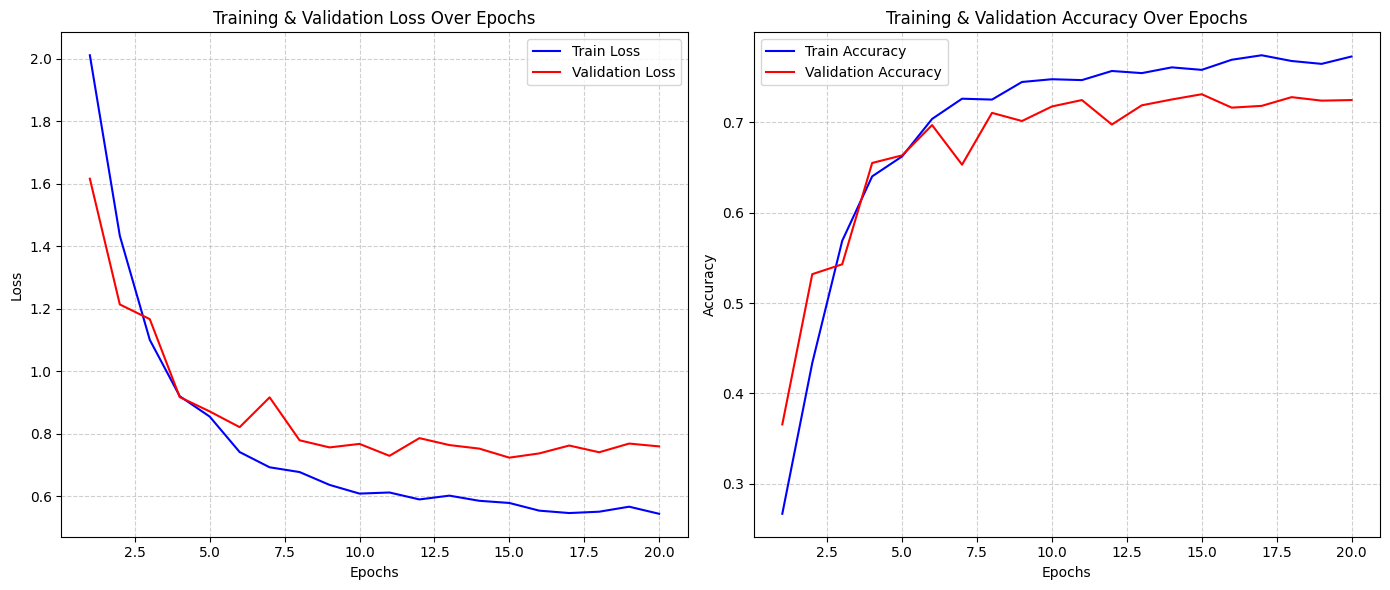

In [11]:
history_df = pd.DataFrame({
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
})

# Save history to Excel for future reference
history_df.to_excel('/kaggle/working/rnn_training_data.xlsx', index=False)
print("Training history saved to rnn_training_data.xlsx")

# Plotting
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_df['Epoch'], history_df['Train Loss'], label='Train Loss', color='blue')
plt.plot(history_df['Epoch'], history_df['Validation Loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_df['Epoch'], history_df['Train Accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_df['Epoch'], history_df['Validation Accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [12]:
def evaluate_model(model, criterion, dataloader):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculations
        for inputs, labels in tqdm(dataloader, desc="Evaluating Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy, all_preds, all_labels

# Load the best model saved during training
best_checkpoint_path = f"{save_path_checkpoints}/best_rnn_model.pt"
try:
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"]) # Not strictly needed for eval, but good practice
    best_epoch = checkpoint["epoch"]
    best_val_acc_saved = checkpoint["best_val_acc"]
    
    # Reload vocabulary mappings and max_seq_len for consistent inference
    char_to_idx_loaded = checkpoint["char_to_idx"]
    idx_to_label_loaded = checkpoint["idx_to_label"]
    max_seq_len_loaded = checkpoint["max_seq_len"]

    print(f"\nLoaded best model from epoch {best_epoch} with validation accuracy: {best_val_acc_saved:.4f}")

    # Evaluate on the test set
    start_time_eval = time.time()
    test_loss, test_accuracy, y_pred, y_true = evaluate_model(model, criterion, test_loader)
    end_time_eval = time.time()
    evaluation_time = end_time_eval - start_time_eval

    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Evaluation Time: {evaluation_time:.2f} seconds ({evaluation_time/60:.2f} minutes)")

    # Classification Report
    target_names = [idx_to_label[i] for i in range(num_classes)]
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))

except FileNotFoundError:
    print(f"Error: Best model checkpoint not found at {best_checkpoint_path}. Please ensure training completed successfully.")
except Exception as e:
    print(f"An error occurred while loading or evaluating the model: {e}")


Loaded best model from epoch 15 with validation accuracy: 0.7311


Evaluating Test Set:   0%|          | 0/25 [00:00<?, ?it/s]


Test Loss: 0.6831, Test Accuracy: 0.7331
Test Evaluation Time: 1.05 seconds (0.02 minutes)

Classification Report:
              precision    recall  f1-score   support

     English       0.98      0.95      0.97       208
   Malayalam       0.22      0.67      0.34        89
       Hindi       1.00      0.30      0.46        10
       Tamil       0.00      0.00      0.00        70
  Portugeese       0.93      0.95      0.94       111
      French       0.96      0.97      0.97       152
       Dutch       0.92      0.94      0.93        82
     Spanish       0.93      0.91      0.92       123
       Greek       0.00      0.00      0.00        54
     Russian       0.28      0.52      0.36       104
      Danish       0.87      0.84      0.86        64
     Italian       0.91      0.95      0.93       105
     Turkish       0.94      0.96      0.95        71
    Sweedish       0.91      0.92      0.92       101
      Arabic       0.00      0.00      0.00        81
      German       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# Function to clean text (re-defined or imported from earlier for self-contained cell)
def clean_text_for_inference(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Function to convert text to sequence (re-defined or imported for self-contained cell)
def text_to_sequence_for_inference(text, char_to_idx, max_len):
    unk_id = char_to_idx.get(UNK_TOKEN, 1) # Assuming UNK_TOKEN is at index 1
    sequence = [char_to_idx.get(char, unk_id) for char in text]
    if len(sequence) > max_len:
        sequence = sequence[:max_len]
    else:
        sequence += [char_to_idx[PAD_TOKEN]] * (max_len - len(sequence))
    return sequence

def predict_language(text, model, char_to_idx_map, idx_to_label_map, max_len_val, device):
    model.eval() # Set model to evaluation mode
    cleaned_text = clean_text_for_inference(text)
    sequence = text_to_sequence_for_inference(cleaned_text, char_to_idx_map, max_len=max_len_val)
    
    # Convert list of IDs to a PyTorch tensor, add a batch dimension (unsqueeze(0))
    input_tensor = torch.tensor(sequence, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1) # Get probabilities using softmax
        
        # Get the predicted class ID
        _, predicted_idx = torch.max(probabilities, 1)
        
        # Map the predicted ID back to the language string
        predicted_label = idx_to_label_map[predicted_idx.item()]
        
        # Get the confidence for the predicted label
        confidence = probabilities[0][predicted_idx.item()].item()
    return predicted_label, confidence

print("\n--- Example Predictions ---")
test_sentences = [
    "Hello, how are you?", # English
    "Bonjour, comment ça va?", # French
    "Hola, ¿cómo estás?", # Spanish
    "Hallo, wie geht es dir?", # German
    "नमस्ते, आप कैसे हैं?", # Hindi
    "Mēs runājam latviski.", # Latvian (from the dataset)
    "Je ne parle pas français." # French
]

# Ensure that char_to_idx_loaded, idx_to_label_loaded, and max_seq_len_loaded
# were successfully loaded from the checkpoint in the previous cell.
# If the checkpoint loading failed, these variables might not be defined.
try:
    for sentence in test_sentences:
        language, confidence = predict_language(sentence, model, char_to_idx_loaded, idx_to_label_loaded, max_seq_len_loaded, device)
        print(f"Text: '{sentence}' -> Predicted Language: {language} (Confidence: {confidence:.2f})")
except NameError:
    print("Error: Model components (char_to_idx_loaded, idx_to_label_loaded, max_seq_len_loaded) not loaded. Please ensure the model checkpoint was successfully loaded in the previous cell.")


--- Example Predictions ---
Text: 'Hello, how are you?' -> Predicted Language: English (Confidence: 1.00)
Text: 'Bonjour, comment ça va?' -> Predicted Language: French (Confidence: 0.98)
Text: 'Hola, ¿cómo estás?' -> Predicted Language: Spanish (Confidence: 1.00)
Text: 'Hallo, wie geht es dir?' -> Predicted Language: German (Confidence: 0.91)
Text: 'नमस्ते, आप कैसे हैं?' -> Predicted Language: Malayalam (Confidence: 0.28)
Text: 'Mēs runājam latviski.' -> Predicted Language: Turkish (Confidence: 0.89)
Text: 'Je ne parle pas français.' -> Predicted Language: French (Confidence: 1.00)
